In [1]:
import torch

In [6]:
import os
import re
import pandas as pd
import numpy as np

def extract_values(line):
    pattern = r"Result: \((\d+), \{'Accuracy': ([\d.]+), 'APS': \(([\d.]+), ([\d.]+)\), 'APSeps05': \(([\d.]+), ([\d.]+)\)\}\)"
    match = re.search(pattern, line)
    if match:
        result_num = int(match.group(1))
        accuracy = float(match.group(2))
        coverage_90 = float(match.group(3))
        aps_score = float(match.group(4))
        coverage_95 = float(match.group(5))
        apseps05_score = float(match.group(6))
        return result_num, accuracy, coverage_90, aps_score, coverage_95, apseps05_score
    else:
        raise ValueError(f"Could not extract values from line: {line}")

def parse_filename(filename):
    parts = filename.replace('.txt', '').split('_')
    
    # Determine if the dataset is biased or unbiased
    dataset_type = 'biased' if 'train' in parts else 'unbiased'
    
    data = {
        'dataset_type': dataset_type,
        'dataset': '',
        'model': '',
        'conformal_score': '',
        'method': 'CE',  # Default method
        'alpha_bias': '0.1' if dataset_type == 'biased' else '1.0'  # Default for biased datasets if not specified
    }
    
    for i, part in enumerate(parts):
        if part in ['cora', 'citeseer', 'PubMed']:
            data['dataset'] = part
        elif part in ['APPNP', 'GAT', 'GCN', 'GraphSAGE', 'DAGNN']:
            data['model'] = part
        elif part in ['aps', 'raps']:
            data['conformal_score'] = part
        elif part in ['SRGNN', 'cmd', 'MMD', 'SRKL', 'SRJS', 'kld', 'jsd', 'emd']:
            data['method'] = part
        elif part == 'alpha' and i + 1 < len(parts) and parts[i + 1] == 'bias':
            data['alpha_bias'] = parts[i + 2]
    
    # Override the default alpha_bias if explicitly mentioned in the filename
    for part in parts:
        if part in ['0.2', '0.45', '0.65'] and dataset_type == 'biased':
            data['alpha_bias'] = part
    
    return data

def process_files(folder_path):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                content = file.read()
                lines = content.strip().split('\n')
                values = [extract_values(line) for line in lines if line.strip()]
                
                if values:
                    _, *metric_values = zip(*values)
                    means = np.mean(metric_values, axis=1)
                    stds = np.std(metric_values, axis=1)
                    result = [f"{mean:.4f} ± {std:.4f}" for mean, std in zip(means, stds)]
                    
                    file_info = parse_filename(filename)
                    data.append(list(file_info.values()) + result)
    
    return data

def create_csv(data, output_file):
    columns = ['Dataset Type', 'Dataset', 'Model', 'Conformal Score', 'Method', 'Alpha Bias',
               'Accuracy', '90% Coverage', 'Prediction Size (90% Coverage)', '95% Coverage', 'Prediction Size (95% Coverage)']
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_file, index=False)
    print(f"CSV file created: {output_file}")

# Usage
folder_path = r'D:\csr\CondSR\pred'  # Using raw string for Windows path
output_file = 'comprehensive_predictions_summary.csv'

data = process_files(folder_path)
create_csv(data, output_file)


CSV file created: comprehensive_predictions_summary.csv


In [31]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction Size (90% Coverage)_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)

# Plot 1: Alpha Bias vs Accuracy from the Perspective of Methods
fig1 = px.box(
    data,
    x='Alpha Bias',
    y='Accuracy_mean',
    color='Method',
    title='Alpha Bias vs Accuracy by Methods',
    labels={'Accuracy_mean': 'Accuracy'}
)
fig1.show()

# Plot 2: Alpha Bias vs APS Score from the Perspective of Methods
fig2 = px.box(
    data,
    x='Alpha Bias',
    y='Prediction Size (90% Coverage)_mean',
    color='Method',
    title='Alpha Bias vs APS Score fby Methods',
    labels={'Prediction Size (90% Coverage)_mean': 'Prediction Size (90% Coverage)'}
)
fig2.show()

# Plot 3: Accuracy vs APS Score from the Perspective of Methods
fig3 = px.scatter(
    data,
    x='Accuracy_mean',
    y='Prediction Size (90% Coverage)_mean',
    color='Method',
    title='Accuracy vs Prediction Size (90% Coverage) by Methods',
    labels={'Accuracy_mean': 'Accuracy', 'Prediction Size (90% Coverage)_mean': 'Prediction Size (90% Coverage)'}
)
fig3.show()

# Plot 4: Accuracy vs Methods for the Models (color by Model)
fig4 = px.box(
    data,
    x='Method',
    y='Accuracy_mean',
    color='Model',
    title='Accuracy vs Methods by the Models',
    labels={'Accuracy_mean': 'Accuracy'}
)
fig4.show()


In [19]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Filter data for Cora dataset with alpha_bias = 0.1
cora_data = data[(data['Dataset'] == 'cora') & (data['Alpha Bias'] == 0.1)]

# Check if the filtered dataset is empty
if cora_data.empty:
    print("No data found for Cora dataset with alpha_bias 0.1")
else:
    # Plot 1: Accuracy vs Prediction Size (90% Coverage) colored by Method
    fig1 = px.scatter(
        cora_data,
        x='Prediction_Size_90_mean',
        y='Accuracy_mean',
        color='Method',
        title='Cora - Accuracy vs Prediction Size (90% Coverage) by Methods',
        labels={'Prediction_Size_90_mean': 'Prediction Size (90% Coverage)', 'Accuracy_mean': 'Accuracy'}
    )
    fig1.update_layout(yaxis_title="Accuracy", xaxis_title="Prediction Size (90% Coverage)")
    fig1.show()

    # Plot 2: Accuracy vs Methods
    fig2 = px.box(
        cora_data,
        x='Method',
        y='Accuracy_mean',
        #color='Model',
        title='Cora - Accuracy vs Methods',
        labels={'Accuracy_mean': 'Accuracy'}
    )
    fig2.update_layout(yaxis_title="Accuracy", xaxis_title="Method")
    fig2.show()

    # Plot 3: 90% Coverage vs Methods by Models
    fig3 = px.box(
        cora_data,
        x='Method',
        y='Coverage_90_mean',
        #color='Model',
        title='Cora - 90% Coverage vs Methods by Models',
        labels={'Coverage_90_mean': '90% Coverage'}
    )
    fig3.update_layout(yaxis_title="90% Coverage", xaxis_title="Method")
    fig3.show()

    # Plot 4: Prediction Size (90% Coverage) vs Methods by Models
    fig4 = px.box(
        cora_data,
        x='Method',
        y='Prediction_Size_90_mean',
        #color='Model',
        title='Cora - Prediction Size (90% Coverage) vs Methods by Models',
        labels={'Prediction_Size_90_mean': 'Prediction Size (90% Coverage)'}
    )
    fig4.update_layout(yaxis_title="Prediction Size (90% Coverage)", xaxis_title="Method")
    fig4.show()


In [28]:
import pandas as pd

# Load the CSV file
file_path = 'comprehensive_predictions_summary.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Filter data for Cora dataset with alpha_bias = 0.1
cora_data_alpha_01 = data[(data['Dataset'] == 'cora') & (data['Alpha Bias'] == 0.1)]

# Save the filtered data to a new CSV file
output_file_path = 'cora_alpha_0.1.csv'
cora_data_alpha_01.to_csv(output_file_path, index=False)


In [4]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Load the data
df = pd.read_csv('cora_alpha_0.1.csv')

# 1. Accuracy vs Prediction Size (90% Coverage) - Scatter plot
fig1 = px.scatter(df, x='Prediction_Size_90_mean', y='Accuracy_mean', color='Method',
                  title='Accuracy vs Prediction Size (90% Coverage)',
                  labels={'Prediction_Size_90_mean': 'Prediction Size (90% Coverage)',
                          'Accuracy_mean': 'Accuracy'},
                  hover_data=['Model'])

# 2. Accuracy vs Methods - Grouped Bar plot
fig2 = go.Figure()

for model in df['Model'].unique():
    model_data = df[df['Model'] == model]
    fig2.add_trace(go.Bar(
        x=model_data['Method'],
        y=model_data['Accuracy_mean'],
        name=model,
        text=model_data['Accuracy_mean'].round(4),
        textposition='auto'
    ))

fig2.update_layout(
    title='Accuracy vs Methods (Grouped by Model)',
    xaxis_title='Method',
    yaxis_title='Accuracy',
    barmode='group'
)

# 3. Methods vs 90% Coverage - Box plot
fig3 = px.box(df, x='Method', y='Coverage_90_mean',
              title='Methods vs 90% Coverage',
              labels={'Coverage_90_mean': '90% Coverage'})

# 4. Methods vs Prediction Size (90% Coverage) - Box plot
fig4 = px.box(df, x='Method', y='Prediction_Size_90_mean',
              title='Methods vs Prediction Size (90% Coverage)',
              labels={'Prediction_Size_90_mean': 'Prediction Size (90% Coverage)'})

# Update layout for better readability
for fig in [fig1, fig2, fig3, fig4]:
    fig.update_layout(
        font=dict(size=12),
        xaxis_title_font=dict(size=14),
        yaxis_title_font=dict(size=14),
        legend_title_font=dict(size=14),
        title_font=dict(size=16)
    )
    fig.update_xaxes(tickangle=45)

# Show the plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()

In [1]:
import os
import re
import pandas as pd
import numpy as np

def extract_values(line):
    pattern = r"Result: \((\d+), \{'Accuracy': ([\d.]+), 'APS': \(([\d.]+), ([\d.]+)\), 'APSeps05': \(([\d.]+), ([\d.]+)\)\}\)"
    match = re.search(pattern, line)
    if match:
        result_num = int(match.group(1))
        accuracy = float(match.group(2))
        coverage_90 = float(match.group(3))
        aps_score = float(match.group(4))
        coverage_95 = float(match.group(5))
        apseps05_score = float(match.group(6))
        return result_num, accuracy, coverage_90, aps_score, coverage_95, apseps05_score
    else:
        raise ValueError(f"Could not extract values from line: {line}")

def parse_filename(filename):
    parts = filename.replace('.txt', '').split('_')
    
    # Determine if the dataset is biased or unbiased
    dataset_type = 'biased' if 'train' in parts else 'unbiased'
    
    data = {
        'dataset_type': dataset_type,
        'dataset': '',
        'model': '',
        'conformal_score': '',
        'method': 'CE',  # Default method
        'alpha_bias': '0.1' if dataset_type == 'biased' else '1.0',  # Default for biased datasets if not specified
        'lmd': '-1' if dataset_type == 'biased' else '0'  # Use -1 for lmd in biased datasets
    }
    
    for i, part in enumerate(parts):
        if part in ['cora', 'citeseer', 'PubMed']:
            data['dataset'] = part
        elif part in ['APPNP', 'GAT', 'GCN', 'GraphSAGE', 'DAGNN']:
            data['model'] = part
        elif part in ['aps', 'raps']:
            data['conformal_score'] = part
        elif part in ['SRGNN', 'cmd', 'MMD','CEMD', 'CKLJS','CKLJSEM', 'CKL', 'CJS', 'kld', 'jsd', 'emd', 'CE']:
            data['method'] = part
        elif part == 'alpha' and i + 1 < len(parts) and parts[i + 1] == 'bias':
            data['alpha_bias'] = parts[i + 2]
        elif part == 'lmd' and i + 1 < len(parts):
            data['lmd'] = parts[i + 1]
    
    # Override the default alpha_bias if explicitly mentioned in the filename
    for part in parts:
        if part in ['0.2', '0.4', '0.6'] and dataset_type == 'biased':
            data['alpha_bias'] = part
    
    return data

def process_files(folder_path):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                content = file.read()
                lines = content.strip().split('\n')
                values = [extract_values(line) for line in lines if line.strip()]
                
                if values:
                    _, *metric_values = zip(*values)
                    means = np.mean(metric_values, axis=1)
                    stds = np.std(metric_values, axis=1)
                    result = [f"{mean:.4f} ± {std:.4f}" for mean, std in zip(means, stds)]
                    
                    file_info = parse_filename(filename)
                    data.append(list(file_info.values()) + result)
    
    return data

def create_csv(data, output_file):
    columns = ['Dataset Type', 'Dataset', 'Model', 'Conformal Score', 'Method', 'Alpha Bias', 'LMD',
               'Accuracy', '90% Coverage', 'Prediction Size (90% Coverage)', '95% Coverage', 'Prediction Size (95% Coverage)']
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_file, index=False)
    print(f"CSV file created: {output_file}")

# Usage
folder_path = r'D:\csr\CondSR\pred'  # Using raw string for Windows path
output_file = 'comprehensive_predictions_summary_2.csv'

data = process_files(folder_path)
create_csv(data, output_file)


CSV file created: comprehensive_predictions_summary_2.csv


In [2]:
import pandas as pd

# Load the CSV file
file_path = 'comprehensive_predictions_summary_2.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Save the updated CSV
updated_file_path = 'comprehensive_predictions_summary_2.csv'
data.to_csv(updated_file_path, index=False)
print(f"Updated CSV file created: {updated_file_path}")


Updated CSV file created: comprehensive_predictions_summary_2.csv


In [1]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Retain all LMD values, including 0
# Filter out LMD values if you want to exclude certain ones
# data = data[data['LMD'].isin([0.1, 0.3, 0.5, 0.7, 1.0])]

# 1. Accuracy vs Prediction Size (90%), color by methods
fig1 = px.scatter(data, x='Accuracy_mean', y='Prediction_Size_90_mean', color='Method', hover_data=['Model','LD1','LD2','Alpha Bias'])
fig1.update_layout(title='Accuracy vs Prediction Size (90%) by Method', xaxis_title='Accuracy', yaxis_title='Prediction Size (90%)')
fig1.show()

# 2. Accuracy vs Methods, color by models
fig2 = px.scatter(data, x='Method', y='Accuracy_mean', color='Model', hover_data=['LD1','LD2','Alpha Bias'],
                         title='Accuracy vs Methods for Different Models',
                         labels={'Accuracy_mean': 'Accuracy', 'Method': 'Method'},
                         template='plotly_white')

# Add lines connecting points for each model
#fig_scatter.update_traces(mode='lines+markers')

# Show the scatter plot
fig2.show()

# 3. Methods vs 90% Coverage
fig5 = px.box(data, x='Method', y='Coverage_90_mean')
fig5.update_layout(title='Methods vs 90% Coverage', xaxis_title='Method', yaxis_title='90% Coverage')
fig5.show()

# 4. Methods vs Prediction Size (90%)
fig6 = px.box(data, x='Method', y='Prediction_Size_90_mean')
fig6.update_layout(title='Methods vs Prediction Size (90%)', xaxis_title='Method', yaxis_title='Prediction Size (90%)')
fig6.show()


In [2]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Define model-specific symbols
model_symbol_map = {
    'Model1': 'circle',
    'Model2': 'square',
    'Model3': 'diamond',
    'Model4': 'cross',
    'Model5': 'triangle-up'
}

# Apply symbols based on the model
data['Model_Symbol'] = data['Model'].map(model_symbol_map)

# Create scatter plot with color by method and symbol by model
fig1 = px.scatter(
    data,
    x='Accuracy_mean',
    y='Prediction_Size_90_mean',
    color='Method',  # Color by method (as before)
    symbol='Model',  # Different symbols for models
    symbol_sequence=['circle', 'square', 'diamond', 'cross', 'triangle-up'],  # Define symbol sequence for models
    hover_data=['Model', 'LD1', 'LD2', 'Alpha Bias']
)



# Update layout to keep it clean and suitable for a research paper
fig1.update_layout(
    title='Accuracy vs Prediction Size (90%) by Method, with Model Symbols',
    xaxis_title='Accuracy',
    yaxis_title='Prediction Size (90%)',
    legend_title="Method",  # Method legend remains as it is
    annotations=[
        dict(
            text="Note: Different symbols represent different models",
            xref="paper", yref="paper",
            x=1, y=1, showarrow=False,
            xanchor="right", yanchor="top",
            font=dict(size=10, color="black")
        )
    ]
)

# Show the figure
fig1.show()


In [18]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Define method-specific symbols
method_symbol_map = {
    'Method1': 'circle',
    'Method2': 'square',
    'Method3': 'diamond',
    'Method4': 'cross',
    'Method5': 'triangle-up',
    'Method5': 'triangle-down',
    'Method6': 'star',
    'Method7' : 'asterisk'
}

# Apply symbols based on the Method
data['Method_Symbol'] = data['Method'].map(method_symbol_map)

# Create scatter plot with color by method and symbol by model
fig1 = px.scatter(
    data,
    x='Accuracy_mean',
    y='Prediction_Size_90_mean',
    color='Model',  # Color by model (as before)
    symbol='Method',  # Different symbols for method
    symbol_sequence=['circle', 'hexagram', 'diamond', 'cross', 'triangle-up','triangle-down','star'],  # Define symbol sequence for models
    hover_data=['Method', 'LD1', 'LD2', 'Alpha Bias']
)



# Update layout to keep it clean and suitable for a research paper
fig1.update_layout(
    title='Accuracy vs Prediction Size (90%) by Model, with Method Symbols',
    xaxis_title='Accuracy',
    yaxis_title='Prediction Size (90%)',
    legend_title="Model",  # model legend remains as it is
    annotations=[
        dict(
            text="Note: Different symbols represent different methods",
            xref="paper", yref="paper",
            x=1, y=1, showarrow=False,
            xanchor="right", yanchor="top",
            font=dict(size=10, color="black")
        )
    ]
)

# Show the figure
fig1.show()


In [21]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Define method-specific symbols
method_symbol_map = {
    'Method1': 'circle',
    'Method2': 'square',
    'Method3': 'diamond',
    'Method4': 'cross',
    'Method5': 'triangle-up',
    'Method6': 'triangle-down',
    'Method7': 'star',
}

# Apply symbols based on the Method
data['Method_Symbol'] = data['Method'].map(method_symbol_map)

# Define models and their corresponding colors
model_color_map = {
    'Model1': 'blue',
    'Model2': 'green',
    'Model3': 'red',
    'Model4': 'purple',
    'Model5': 'orange'
}

# Create base scatter plot with color by model and symbol by method
fig = px.scatter(
    data,
    x='Accuracy_mean',
    y='Prediction_Size_90_mean',
    color='Model',
    symbol='Method',
    symbol_sequence=['circle', 'hexagram', 'diamond', 'cross', 'triangle-up', 'triangle-down', 'star'],
    hover_data=['Method', 'LD1', 'LD2', 'Alpha Bias'],
    title="Accuracy vs Prediction Size (90%) by Model, with Method Symbols"
)

# Create a custom legend for methods (symbols) and models (colors)
legend_items = []

# Add method symbols
for method, symbol in method_symbol_map.items():
    legend_items.append(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(symbol=symbol, size=10, color='black'),
            showlegend=False,
            name=f'{method}'
        )
    )

# Add model colors
for model, color in model_color_map.items():
    legend_items.append(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            showlegend=False,
            name=f'{model}'
        )
    )

# Add the custom legend to the figure
for item in legend_items:
    fig.add_trace(item)

# Position the custom legend on the right and add visual notes for color and symbol codes
# fig.add_annotation(
#     text="<b>Legend</b><br><br>" +
#          "<b>Methods:</b><br>" +
#          "&#11044; CJS<br>" +
#          "&&#10006; hexagram<br>" +
#          "&#9670; SRGNN<br>" +
#          "&#10006; cmd<br>" +
#          "&#9650; jsd<br>" +
#          "&#9660; kld<br>" +
#          "&#9733; MMD<br>" +

#          "<b>Models:</b><br>" +
#          "<span style='color:blue;'>&#11044; APPNP</span><br>" +
#          "<span style='color:green;'>&#11044; GAT</span><br>" +
#          "<span style='color:red;'>&#11044; DAGNN</span><br>" +
#          "<span style='color:purple;'>&#11044; GCaN</span><br>" +
#          "<span style='color:orange;'>&#11044; GraphSage</span>",
#     align="left",
#     showarrow=False,
#     xref="paper", yref="paper",
#     x=1.05, y=1,
#     bordercolor="black",
#     borderwidth=1,
#     bgcolor="white",
#     font=dict(size=12)
# )

# Update layout to avoid overlap with the custom legend
fig.update_layout(
    title='Accuracy vs Prediction Size (90%) by Model, with Method Symbols',
    xaxis_title='Accuracy',
    yaxis_title='Prediction Size (90%)',
    margin=dict(r=300),  # Add extra space on the right for the legend
    height=600,
    width=1000,
    legend=dict(x=1.02, y=1)  # Move default legend
)

# Show the figure
fig.show()


In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Define method-specific symbols (using hexagram instead of square)
method_symbol_map = {
    'Method1': 'circle',
    'Method2': 'hexagram',  # changed from square to hexagram
    'Method3': 'diamond',
    'Method4': 'cross',
    'Method5': 'triangle-up',
    'Method6': 'triangle-down',
    'Method7': 'star',
}

# Apply symbols based on the Method
data['Method_Symbol'] = data['Method'].map(method_symbol_map)

# Define models and their corresponding colors
model_color_map = {
    'Model1': 'blue',
    'Model2': 'green',
    'Model3': 'red',
    'Model4': 'purple',
    'Model5': 'orange'
}

# Create base scatter plot with color by model and symbol by method
fig = px.scatter(
    data,
    x='Accuracy_mean',
    y='Prediction_Size_90_mean',
    color='Model',
    symbol='Method',
    symbol_sequence=['circle', 'hexagram', 'diamond', 'cross', 'triangle-up', 'triangle-down', 'star'],
    hover_data=['Method', 'LD1', 'LD2', 'Alpha Bias'],
    title="Accuracy vs Prediction Size (90%) by Model, with Method Symbols"
)

# Create a custom legend for methods (symbols) and models (colors)
legend_items = []

# Add method symbols
for method, symbol in method_symbol_map.items():
    legend_items.append(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(symbol=symbol, size=10, color='black'),
            showlegend=False,
            name=f'{method}'
        )
    )

# Add model colors
for model, color in model_color_map.items():
    legend_items.append(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            showlegend=False,
            name=f'{model}'
        )
    )

# Add the custom legend to the figure
for item in legend_items:
    fig.add_trace(item)

# Adjust the custom legend (models and methods side-by-side)
fig.add_annotation(
    text="<b>Legend</b><br><br>" +
         "<b>Models:</b> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>Methods:</b><br>" +
         "<span style='color:blue;'>&#11044; APPNP</span> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &#11044; CJS<br>" +
         "<span style='color:green;'>&#11044; GAT</span> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &#11045; CKL (hexagram)<br>" +
         "<span style='color:red;'>&#11044; DAGNN</span> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9670; SRGNN<br>" +
         "<span style='color:purple;'>&#11044; GCaN</span> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#10006; cmd<br>" +
         "<span style='color:orange;'>&#11044; GraphSage</span> &nbsp;&nbsp;&nbsp;&nbsp;&#9650; jsd<br>" +
         "&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9660; kld<br>" +
         "&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9733; MMD<br>",
    align="left",
    showarrow=False,
    xref="paper", yref="paper",
    x=1.05, y=1,
    bordercolor="black",
    borderwidth=1,
    bgcolor="white",
    font=dict(size=12)
)

# Update layout to avoid overlap with the custom legend
fig.update_layout(
    title='Accuracy vs Prediction Size (90%) by Model, with Method Symbols',
    xaxis_title='Accuracy',
    yaxis_title='Prediction Size (90%)',
    margin=dict(r=350),  # Add extra space on the right for the legend
    height=800,  # Adjust the plot height to give more space for legend
    width=1200,  # Adjust the plot width
    legend=dict(x=1.02, y=1)  # Move default legend
)

# Show the figure
fig.show()


In [22]:
import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'  # replace with your file path
df = pd.read_csv(file_path)

# Extract unique models and methods
models = df['Model'].unique()
methods = df['Method'].unique()

# Define symbols for different methods
symbols = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down']

# Loop through each model and create separate plots for each
for model in models:
    # Filter data for the current model
    model_data = df[df['Model'] == model]
    
    # Create a figure for the current model
    fig = go.Figure()
    
    # Loop through each method and plot data with hover data
    for i, method in enumerate(methods):
        method_data = model_data[model_data['Method'] == method]
        
        fig.add_trace(go.Scatter(
            x=method_data['Accuracy_mean'],  # Accuracy on the x-axis
            y=method_data['Prediction_Size_90_mean'],  # Prediction Size on the y-axis
            mode='markers',  # Only markers, no lines
            name=method,
            marker=dict(symbol=symbols[i], size=10),  # Use different symbols
            hovertemplate=(
                'Method: %{text}<br>' +
                'LD1: %{customdata[0]}<br>' +
                'LD2: %{customdata[1]}<br>' +
                'Alpha Bias: %{customdata[2]}<br>' +
                'Accuracy: %{x}<br>' +
                'Prediction Size: %{y}<extra></extra>'
            ),
            text=method_data['Method'],  # For hover display
            customdata=method_data[['LD1', 'LD2', 'Alpha Bias']]  # Additional hover data
        ))

    # Update the layout for better visibility
    fig.update_layout(
        title=f" Accuracy vs Prediction Set Size for model : {model}",
        xaxis_title="Accuracy",  # Accuracy on x-axis
        yaxis_title="Prediction Set Size",  # Prediction Size on y-axis
        height=700,  # Set height for better visibility
        width=900,   # Set width for better visibility
        legend_title="Method",
        font=dict(size=14)
    )

    # Show the figure
    fig.show()


In [23]:
import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'  # replace with your file path
df = pd.read_csv(file_path)

# Extract unique models and methods
models = df['Model'].unique()
methods = df['Method'].unique()

# Define symbols for different models
symbols = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'star']

# Loop through each method and create separate plots for each
for method in methods:
    # Filter data for the current method
    method_data = df[df['Method'] == method]
    
    # Create a figure for the current method
    fig = go.Figure()
    
    # Loop through each model and add a scatter plot
    for i, model in enumerate(models):
        model_data = method_data[method_data['Model'] == model]
        
        fig.add_trace(go.Scatter(
            x=model_data['Accuracy_mean'],  # Accuracy on the x-axis
            y=model_data['Prediction_Size_90_mean'],  # Prediction Size on the y-axis
            mode='markers',  # Only markers, no lines
            name=model,
            marker=dict(symbol=symbols[i], size=10),  # Different symbols for each model
            hovertemplate=(
                'Model: %{text}<br>' +
                'LD1: %{customdata[0]}<br>' +
                'LD2: %{customdata[1]}<br>' +
                'Alpha Bias: %{customdata[2]}<br>' +
                'Accuracy: %{x}<br>' +
                'Prediction Size: %{y}<extra></extra>'
            ),
            text=model_data['Model'],  # Hover text to show the model
            customdata=model_data[['LD1', 'LD2', 'Alpha Bias']]  # Additional hover data
        ))

    # Update the layout for the current figure
    fig.update_layout(
        title=f"Prediction Set Size vs Accuracy for Method: {method}",
        xaxis_title="Accuracy",
        yaxis_title="Prediction Set Size",
        height=700,  # Set height for better visibility
        width=900,   # Set width for better visibility
        legend_title="Model",
        font=dict(size=14)
    )

    # Show the figure for the current method
    fig.show()


In [20]:
# Create a figure for the boxplots
fig = go.Figure()

# Loop through each method and add a boxplot for Prediction Size
for method in methods:
    method_data = df[df['Method'] == method]
    
    fig.add_trace(go.Box(
        y=method_data['Prediction_Size_90_mean'],  # Coverage (Prediction Size)
        name=method,  # Method name for the x-axis labels
        boxmean=True,  # Show mean
        boxpoints='all',  # Show all points within the box
        hovertemplate=(
            'Method: %{x}<br>' +
            'Coverage: %{y}<extra></extra>'
        )
    ))

# Update layout for the boxplot figure
fig.update_layout(
    title="Boxplots of Prediction Set Size for Different Methods",
    xaxis_title="Method",
    yaxis_title="Prediction Set Size",
    height=700,  # Adjust height for readability
    width=1000,  # Adjust width for readability
    font=dict(size=14)
)

# Show the boxplot figure
fig.show()


In [19]:
import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'  # replace with your file path
df = pd.read_csv(file_path)

# Extract unique models and methods
models = df['Model'].unique()
methods = df['Method'].unique()

# Define symbols for different methods
symbols = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down']

# Loop through each model and create separate plots for each
for model in models:
    # Filter data for the current model
    model_data = df[df['Model'] == model]
    
    # Create a figure for the current model
    fig = go.Figure()

    # Loop through each method and add the scatter plot
    for i, method in enumerate(methods):
        method_data = model_data[model_data['Method'] == method]
        
        fig.add_trace(go.Scatter(
            x=[method] * len(method_data),  # Method on the x-axis
            y=method_data['Coverage_90_mean'],  # Coverage (Prediction Size) on the y-axis
            mode='markers',  # Only markers, no lines
            name=method,
            marker=dict(symbol=symbols[i], size=10),  # Use different symbols for methods
            hovertemplate=(
                'Method: %{text}<br>' +
                'LD1: %{customdata[0]}<br>' +
                'LD2: %{customdata[1]}<br>' +
                'Alpha Bias: %{customdata[2]}<br>' +
                'Coverage: %{y}<extra></extra>'
            ),
            text=method_data['Method'],  # Hover display
            customdata=method_data[['LD1', 'LD2', 'Alpha Bias']]  # Additional hover data
        ))

    # Update layout for each figure
    fig.update_layout(
        title=f"Method vs Coverage for Model: {model}",
        xaxis_title="Method",
        yaxis_title="Coverage",
        height=600,  # Adjust height for better readability
        width=900,   # Adjust width for better readability
        font=dict(size=14),
        showlegend=True,  # Display legend to distinguish methods
        legend_title="Method"
    )
    
    # Show the figure for the current model
    fig.show()


In [17]:
import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'  # replace with your file path
df = pd.read_csv(file_path)

# Extract unique models and methods
models = df['Model'].unique()
methods = df['Method'].unique()

# Loop through each model and create separate boxplots for each
for model in models:
    # Filter data for the current model
    model_data = df[df['Model'] == model]
    
    # Create a figure for the current model
    fig = go.Figure()

    # Loop through each method and add the boxplot
    for method in methods:
        method_data = model_data[model_data['Method'] == method]
        
        fig.add_trace(go.Box(
            y=method_data['Prediction_Size_90_mean'],  # Prediction Size on the y-axis
            name=method,  # Method on the x-axis
            boxmean=True,  # Display the mean in the boxplot
            boxpoints='all',  # Show all points within the boxplot
            hovertemplate=(
                'Method: %{x}<br>' +
                'LD1: %{customdata[0]}<br>' +
                'LD2: %{customdata[1]}<br>' +
                'Alpha Bias: %{customdata[2]}<br>' +
                'Coverage: %{y}<extra></extra>'
            ),
            customdata=method_data[['LD1', 'LD2', 'Alpha Bias']]  # Additional hover data
        ))

    # Update layout for each figure
    fig.update_layout(
        title=f"Method vs Prediction Size for Model: {model}",
        xaxis_title="Method",
        yaxis_title="Prediction Size (90% Coverage)",
        height=600,  # Adjust height for better readability
        width=900,   # Adjust width for better readability
        font=dict(size=14),
        showlegend=False  # Boxplots typically don't require legends
    )
    
    # Show the figure for the current model
    fig.show()


In [42]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Create bar plot for Accuracy vs Method, colored by Model
fig = px.bar(
    data,
    x='Method',
    y='Accuracy_mean',  # Directly use Accuracy_mean which is already in the range 0 to 1
    color='Model',  # Color by model
    title='Accuracy vs Method, Colored by Model',
    labels={'Accuracy_mean': 'Accuracy', 'Method': 'Method'},
    barmode='group',  # Group bars by model
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Method',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1]),  # Set y-axis to range from 0 to 1
    legend_title="Model"
)

# Show the figure
fig.show()


In [7]:
import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'  # replace with your file path
df = pd.read_csv(file_path)

# Convert 'Accuracy_mean' to numeric (ensure no rounding or coercion issues)
df['Accuracy_mean'] = pd.to_numeric(df['Accuracy_mean'], errors='coerce')

# Create a figure
fig = go.Figure()

# Loop through each unique model in the dataset
models = df['Model'].unique()

# Create a bar for each model, but color them distinctly
for model in models:
    # Filter data for each model
    model_data = df[df['Model'] == model]
    
    # Add bars for each method
    fig.add_trace(go.Bar(
        x=model_data['Method'],  # Methods on the x-axis
        y=model_data['Accuracy_mean'],  # Accuracy on the y-axis
        name=model,  # Legend name for the model
        text=model_data['Accuracy_mean'],  # Show accuracy values on bars
        textposition='auto',
        hovertemplate=(
            'Method: %{x}<br>' +
            'Model: %{name}<br>' +
            'Accuracy: %{y:.4f}<extra></extra>'
        )
    ))

# Update layout to remove binning and improve readability
fig.update_layout(
    title="Accuracy vs Method Colored by Model",
    xaxis_title="Method",
    yaxis_title="Accuracy",
    height=600,  # Adjust height
    width=1000,  # Adjust width for better readability
    barmode='group',  # Group the bars by method
    font=dict(size=14),
    showlegend=True,  # Show legend for models
    xaxis_tickangle=-45,  # Rotate x-axis labels for readability
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    yaxis=dict(tickformat='.2f', range=[0.6, 0.8])  # Remove binning and set a fixed range
)

# Display the figure
fig.show()


In [10]:
import pandas as pd
import plotly.graph_objects as go

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'  # replace with your file path
df = pd.read_csv(file_path)

# Convert 'Accuracy_mean' to numeric (ensure no rounding or coercion issues)
df['Accuracy_mean'] = pd.to_numeric(df['Accuracy_mean'], errors='coerce')

# Create a figure
fig = go.Figure()

# Define color map for models
color_map = {
    'APPNP': '#7B68EE',  # Medium slate blue
    'DAGNN': '#FF6347',  # Tomato
    'GAT': '#3CB371',    # Medium sea green
    'GCN': '#9370DB',    # Medium purple
    'GraphSAGE': '#FFA500'  # Orange
}

# Define the order of methods as shown in the image
method_order = ['cmd', 'jsd', 'kld', 'MMD', 'SRGNN', 'CJS', 'CKL']

# Loop through each unique model in the dataset
models = ['APPNP', 'DAGNN', 'GAT', 'GCN', 'GraphSAGE']

for model in models:
    # Filter data for each model
    model_data = df[df['Model'] == model]
    
    # Add bars for each method
    fig.add_trace(go.Bar(
        x=method_order,  # Methods on the x-axis in specified order
        y=[model_data[model_data['Method'] == method]['Accuracy_mean'].values[0] if not model_data[model_data['Method'] == method].empty else None for method in method_order],
        name=model,  # Legend name for the model
        marker_color=color_map[model],
        text=[f"{model_data[model_data['Method'] == method]['Accuracy_mean'].values[0]:.3f}" if not model_data[model_data['Method'] == method].empty else '' for method in method_order],
        textposition='outside',
        textfont=dict(size=9),
        hoverinfo='none'
    ))

# Update layout to match the image
fig.update_layout(
    title={
        'text': "Accuracy vs Methods (Grouped by Model)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Method",
    yaxis_title="Accuracy",
    height=500,
    width=1000,
    barmode='group',
    font=dict(size=12),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    plot_bgcolor='rgba(242,242,242,1)',  # Light gray background
    yaxis=dict(
        tickformat='.2f', 
        range=[0, 0.8],
        dtick=0.2,
        gridcolor='white',
        zerolinecolor='white'
    ),
    xaxis=dict(
        tickangle=0,
        gridcolor='white'
    ),
    bargap=0.15,
    bargroupgap=0.05
)

# Display the figure
fig.show()

In [4]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary_4.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Filter data to include only relevant LMD values
filtered_data = data[data['LMD'].isin([0.1, 0.3, 0.5, 0.7, 1.0])]

# Get the unique methods
methods = filtered_data['Method'].unique()

# Create separate plots for each method
for method in methods:
    method_data = filtered_data[filtered_data['Method'] == method]
    fig = px.bar(method_data, 
                 x='LMD', 
                 y='Accuracy_mean', 
                 color='Model', 
                 barmode='group',
                 title=f'Accuracy vs LMD for Method: {method}',
                 labels={'Accuracy_mean': 'Accuracy', 'LMD': 'LMD Value'})
    
    # Update layout for better visualization
    fig.update_layout(xaxis=dict(tickmode='array', tickvals=[0.1, 0.3, 0.5, 0.7, 1.0]),
                      xaxis_title='LMD',
                      yaxis_title='Accuracy')
    
    fig.show()


In [5]:
import pandas as pd
import plotly.express as px

# Load the CSV file
file_path = 'comprehensive_predictions_summary_2.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Filter data to include only relevant LMD values
filtered_data = data[data['LMD'].isin([0.1, 0.3, 0.5, 0.7, 1.0])]

# Get the unique methods
methods = filtered_data['Method'].unique()

# Create separate plots for each method
for method in methods:
    method_data = filtered_data[filtered_data['Method'] == method]
    fig = px.scatter(method_data, 
                 x='LMD', 
                 y='Prediction_Size_90_mean', 
                 color='Model',
                 title=f'Prediction Size (90% Coverage) vs LMD for Method: {method}',
                 labels={'Prediction_Size_90_mean': 'Prediction Size (90% Coverage)', 'LMD': 'LMD Value'})
    
    # Update layout for better visualization
    fig.update_layout(xaxis=dict(tickmode='array', tickvals=[0.1, 0.3, 0.5, 0.7, 1.0]),
                      xaxis_title='LMD',
                      yaxis_title='Prediction Size (90% Coverage)')
    
    fig.show()


In [6]:

# Load the CSV file
file_path = 'comprehensive_predictions_summary_2.csv'
data = pd.read_csv(file_path)

# Function to extract mean value from the string
def extract_mean(value):
    return float(value.split(' ± ')[0])

# Apply the function to relevant columns to get mean values
data['Accuracy_mean'] = data['Accuracy'].apply(extract_mean)
data['Prediction_Size_90_mean'] = data['Prediction Size (90% Coverage)'].apply(extract_mean)
data['Coverage_90_mean'] = data['90% Coverage'].apply(extract_mean)

# Filter data to include only relevant LMD values
filtered_data = data[data['LMD'].isin([0.1, 0.3, 0.5, 0.7, 1.0])]

# Get the unique methods
methods = filtered_data['Method'].unique()

# Create separate scatter plots with trend lines for each method
for method in methods:
    method_data = filtered_data[filtered_data['Method'] == method]
    fig = px.scatter(method_data, 
                     x='Prediction_Size_90_mean', 
                     y='Accuracy_mean', 
                     color='Model',
                       # Ordinary Least Squares trendline
                     title=f'Accuracy vs Prediction Size (90% Coverage) for Method: {method}',
                     labels={'Accuracy_mean': 'Accuracy', 'Prediction_Size_90_mean': 'Prediction Size (90% Coverage)'})
    
    # Update layout for better visualization
    fig.update_layout(xaxis_title='Prediction Size (90% Coverage)',
                      yaxis_title='Accuracy')
    
    fig.show()


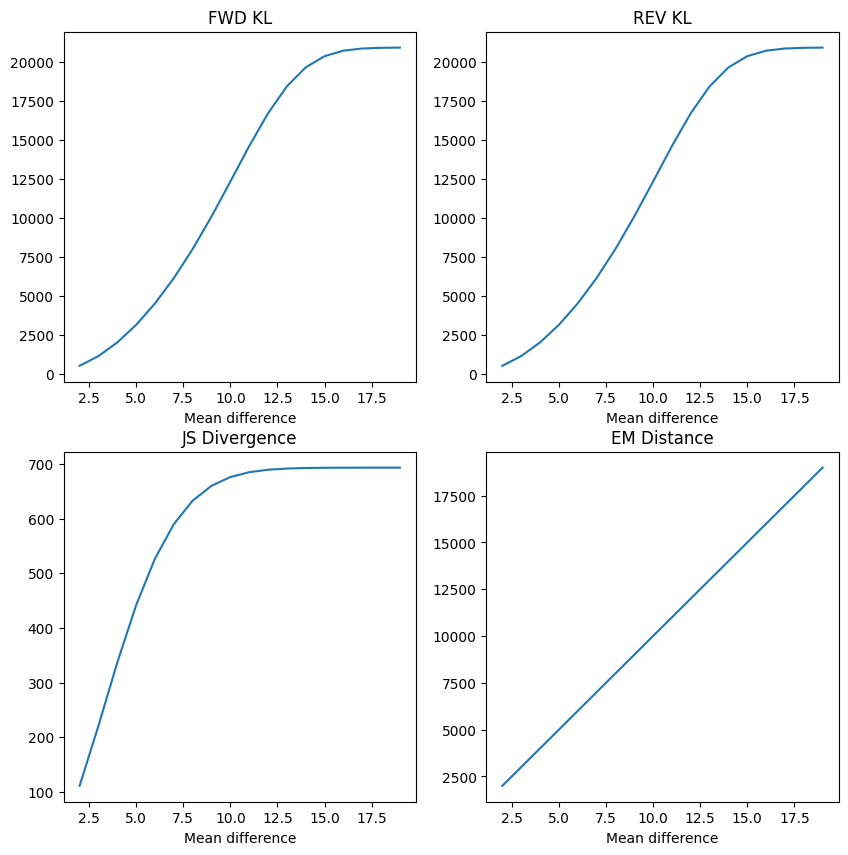

In [2]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import torch

def kld(X, Xtest, epsilon=1e-10):
    """
    Compute KL divergence directly between two tensors.
    
    Args:
    X (torch.Tensor): First tensor
    Xtest (torch.Tensor): Second tensor
    epsilon (float): Small value to avoid log(0) and division by zero
    
    Returns:
    float: The mean KL divergence
    """
    # Ensure inputs are PyTorch tensors
    X = torch.as_tensor(X, dtype=torch.float32)
    Xtest = torch.as_tensor(Xtest, dtype=torch.float32)
    
    # Clamp values to avoid numerical issues
    X = torch.clamp(X, min=epsilon, max=1.0)
    Xtest = torch.clamp(Xtest, min=epsilon, max=1.0)
    
    # Compute KL divergence
    kl_div = torch.sum(X * torch.log(X / Xtest))
    
    # Return mean KL divergence
    return kl_div.item()

def jsd(X, Xtest):
    """
    Compute Jensen-Shannon divergence between two tensors.
    
    Args:
    X (torch.Tensor): First tensor
    Xtest (torch.Tensor): Second tensor
    
    Returns:
    float: The JS divergence
    """
    m = 0.5 * (X + Xtest)
    return 0.5 * (kld(X, m) + kld(Xtest, m))

def emd(X, Xtest):
    """
    Compute Earth Mover's Distance (EMD) between two distributions using PyTorch.
    
    Args:
    X (torch.Tensor): First tensor
    Xtest (torch.Tensor): Second tensor
    
    Returns:
    float: The EMD
    """
    # Ensure inputs are PyTorch tensors
    X = torch.as_tensor(X, dtype=torch.float32)
    Xtest = torch.as_tensor(Xtest, dtype=torch.float32)
    
    # Normalize the distributions
    X = X / torch.sum(X)
    Xtest = Xtest / torch.sum(Xtest)
    
    # Compute the cumulative distributions
    cdf_X = torch.cumsum(X, dim=-1)
    cdf_Xtest = torch.cumsum(Xtest, dim=-1)
    
    # Compute the EMD
    emd = torch.sum(torch.abs(cdf_X - cdf_Xtest))
    
    return emd.item()

# Example usage
x = np.arange(-40, 40, 0.001)
q_mean_range = (2, 20)
fkl = []
bkl = []
js = []
em = []
p = norm.pdf(x, 0, 2)

for i in range(*q_mean_range):
    q = norm.pdf(x, i, 2)
    p_tensor = torch.tensor(p, dtype=torch.float32)
    q_tensor = torch.tensor(q, dtype=torch.float32)
    fkl.append(kld(p_tensor, q_tensor))
    bkl.append(kld(q_tensor, p_tensor))
    js.append(jsd(p_tensor, q_tensor))
    em.append(emd(p_tensor, q_tensor))

x = np.arange(*q_mean_range, 1)
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

for i, (vals, name) in enumerate(zip([fkl, bkl, js, em], ['FWD KL', 'REV KL', 'JS Divergence', 'EM Distance'])):
    ax[i].plot(x, vals)
    ax[i].set_xlabel('Mean difference')
    ax[i].set_title(name)

plt.show()


In [2]:
import torch
import torch.nn.functional as F

# Example tensors for P and Q
P = torch.tensor([[0.1, 0.2, 0.3, 0.4],
                  [0.3, 0.2, 0.2, 0.3],
                  [0.2, 0.2, 0.3, 0.3],
                  [0.4, 0.1, 0.2, 0.3]], dtype=torch.float32)

Q = torch.tensor([[0.2, 0.2, 0.2, 0.4],
                  [0.25, 0.25, 0.25, 0.25],
                  [0.1, 0.3, 0.3, 0.3],
                  [0.3, 0.2, 0.3, 0.2]], dtype=torch.float32)

# Compute element-wise KLD
kld_matrix = p * torch.log(P / Q)

# Compute KLD loss (sum of all elements)
kld_loss = kld_matrix.sum()
print("KLD Loss:", kld_loss.item())

# The KLD matrix shape
print("Shape of KLD Matrix:", kld_matrix.shape)


KLD Loss: 0.2231435477733612
Shape of KLD Matrix: torch.Size([4, 4])
